In [1]:
import sys
assert sys.version_info >= (3, 7)

from packaging import version 
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

import tensorflow as tf 
assert version.parse(tf.__version__) >= version.parse("2.8.0")

import matplotlib.pyplot as plt 

plt.rc("font", size = 14)
plt.rc("axes", labelsize = 14, titlesize = 14)
plt.rc("legend", fontsize = 14)
plt.rc("xtick", labelsize = 12)
plt.rc("ytick", labelsize = 12)

tf.config.list_physical_devices("GPU")

2025-08-28 00:06:46.684625: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-28 00:06:47.066944: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756321607.190620     789 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756321607.230137     789 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756321607.490023     789 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
sys.modules

{'sys': <module 'sys' (built-in)>,
 'builtins': <module 'builtins' (built-in)>,
 '_frozen_importlib': <module '_frozen_importlib' (frozen)>,
 '_imp': <module '_imp' (built-in)>,
 '_thread': <module '_thread' (built-in)>,
 '_warnings': <module '_warnings' (built-in)>,
 '_weakref': <module '_weakref' (built-in)>,
 '_io': <module '_io' (built-in)>,
 'marshal': <module 'marshal' (built-in)>,
 'posix': <module 'posix' (built-in)>,
 '_frozen_importlib_external': <module '_frozen_importlib_external' (frozen)>,
 'time': <module 'time' (built-in)>,
 'zipimport': <module 'zipimport' (frozen)>,
 '_codecs': <module '_codecs' (built-in)>,
 'codecs': <module 'codecs' (frozen)>,
 'encodings.aliases': <module 'encodings.aliases' from '/usr/lib/python3.12/encodings/aliases.py'>,
 'encodings': <module 'encodings' from '/usr/lib/python3.12/encodings/__init__.py'>,
 'encodings.utf_8': <module 'encodings.utf_8' from '/usr/lib/python3.12/encodings/utf_8.py'>,
 '_signal': <module '_signal' (built-in)>,
 '_ab

In [3]:
from sklearn.datasets import load_sample_images

images = load_sample_images()["images"]
images[0].shape


(427, 640, 3)

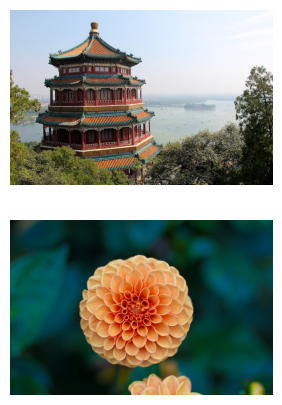

In [4]:
plt.figure(figsize=(5, 5))
plt.subplot(2,1, 1)
plt.imshow(images[0])
plt.axis("off")
plt.subplot(2,1, 2)
plt.imshow(images[1])
plt.axis("off")
plt.show()

In [5]:
images = tf.keras.layers.CenterCrop(height = 70, width = 120)(images)
images = tf.keras.layers.Rescaling(scale = 1/255)(images )
images.shape

I0000 00:00:1756321612.966862     789 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


TensorShape([2, 70, 120, 3])

In [6]:
tf.random.set_seed(42)
convLayer = tf.keras.layers.Conv2D(filters =32 , kernel_size=7)
featureMaps = convLayer(images)
featureMaps.shape

I0000 00:00:1756321613.969436     789 cuda_dnn.cc:529] Loaded cuDNN version 90300


TensorShape([2, 64, 114, 32])

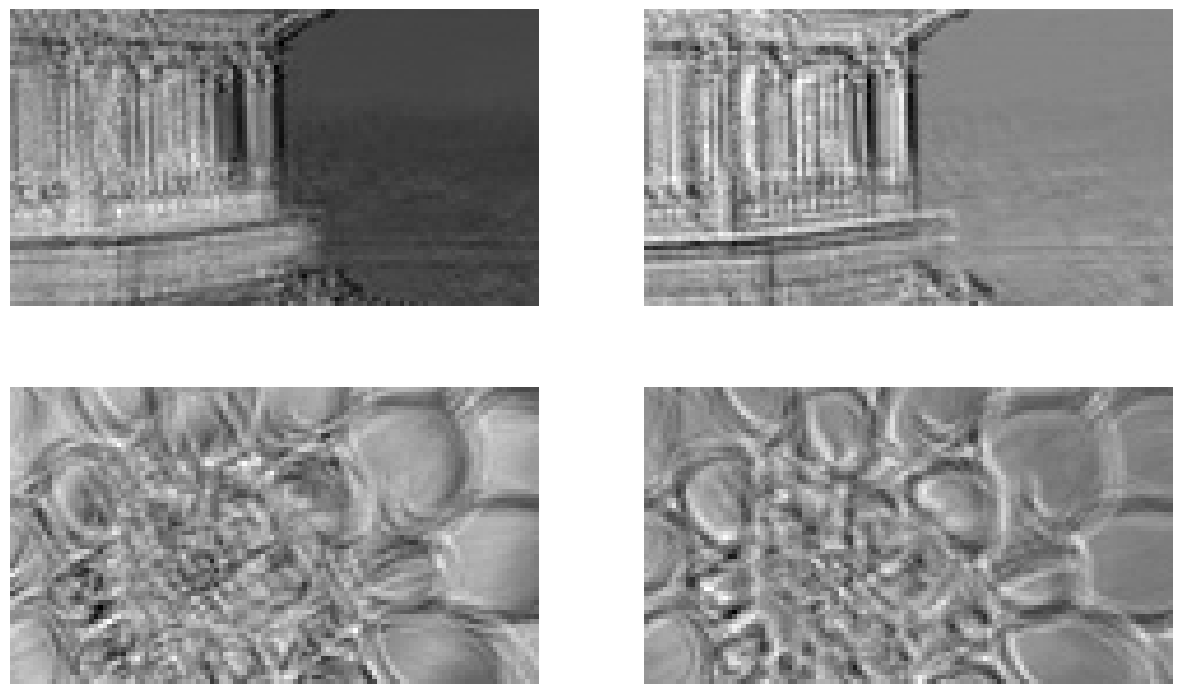

In [7]:
plt.figure(figsize=(15, 9))
for imageId in (0, 1):
    for fmapId in (0,1):
        plt.subplot(2, 2, imageId * 2 + fmapId + 1)
        plt.imshow(featureMaps[imageId, : , : , fmapId], cmap = "gray")
        plt.axis("off")
plt.show()

now with zero padding

In [8]:
convLayerPadding = tf.keras.layers.Conv2D(filters = 32, kernel_size=7, padding="same")
paddedFMaps = convLayerPadding(images)
paddedFMaps.shape

TensorShape([2, 70, 120, 32])

its the same as images shape .
Now with strides

In [9]:
convLayerStridesPadding = tf.keras.layers.Conv2D(
    filters = 32, 
    kernel_size=7, 
    padding="same",
    strides = 2)
paddedStridesFMaps = convLayerStridesPadding(images)
paddedStridesFMaps.shape

TensorShape([2, 35, 60, 32])

In [10]:
weights, biases =convLayer.get_weights()
weights.shape

(7, 7, 3, 32)

manually creating the filters using tf.nn.conv2d

In [11]:
tf.random.set_seed(42)
filters = tf.random.normal([7, 7, 3, 2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images,filters, strides = 1, padding="SAME") + biases
# numimages. width, height, numfilters
fmaps.shape 

TensorShape([2, 70, 120, 2])

manually creating horizontal and verticle filters

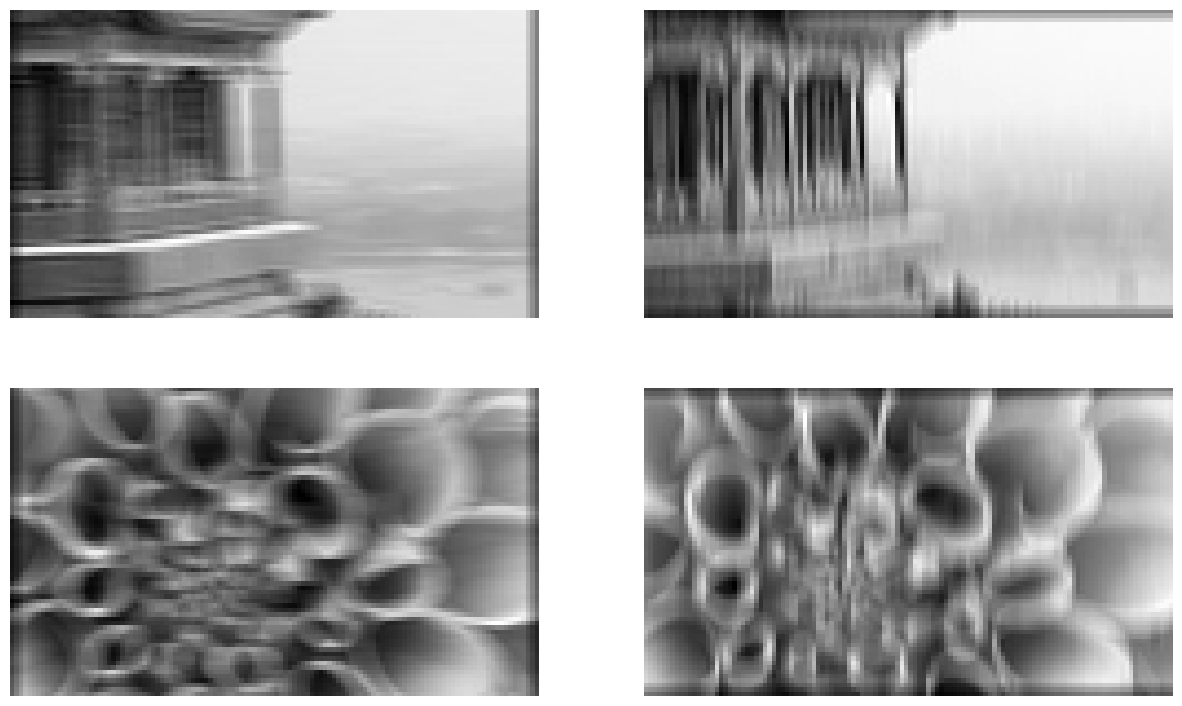

In [12]:
import numpy as np
filters = np.zeros([7, 7, 3, 2])
# horizontal filter
filters[3, :, :, 0] = 1
# verticle filter 
filters[:,3 , :, 1] = 1 
fmaps = tf.nn.conv2d(images, filters, strides = 1, padding = "SAME")

plt.figure(figsize=(15, 9))
for imageId in (0, 1):
    for fmapId in (0, 1):
        plt.subplot(2,2, imageId * 2 + fmapId + 1)
        plt.imshow(fmaps[imageId, :, :,fmapId], cmap= "gray")
        plt.axis("off")
plt.show()

max pooling example

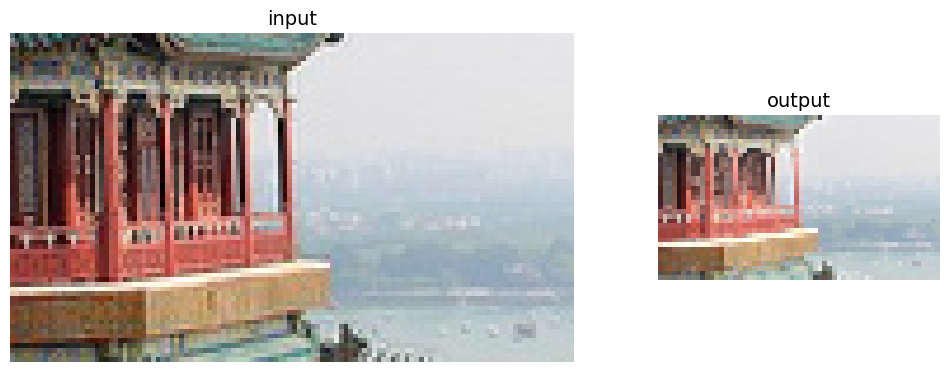

In [13]:
maxPoolLayer = tf.keras.layers.MaxPool2D(pool_size=2)
maxPoolOuput = maxPoolLayer(images)

import matplotlib as mpl 

fig = plt.figure(figsize=(12, 9))
gs = mpl.gridspec.GridSpec(nrows = 1, ncols = 2, width_ratios = [2, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("input")
ax1.axis("off")
ax1.imshow(images[0])

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("output")
ax2.axis("off")
ax2.imshow(maxPoolOuput[0])

plt.show()

In [14]:
# extra code – shows how to use the max_pool() op; only works on the CPU
np.random.seed(42)
fmaps = np.random.rand(2, 70, 120, 60) # last dimension is for number of features
with tf.device("/cpu:0"):
    output = tf.nn.max_pool(fmaps, ksize=(1, 1, 1, 60), strides=(1, 1, 1, 60),
                            padding="VALID")
output.shape

TensorShape([2, 70, 120, 1])

In [15]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
    
    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        # print(f"shape : {shape}")
        groups = shape[-1] // self.pool_size  # number of channel groups
        # print(f"groups : {groups}")
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        # print(f"new_shape : {new_shape}")
        test = tf.reshape(inputs, new_shape)
        # print(f"test.shape : {test.shape}")
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)
    
result = DepthPool(pool_size= 3)(images)
result.shape

TensorShape([2, 70, 120, 1])

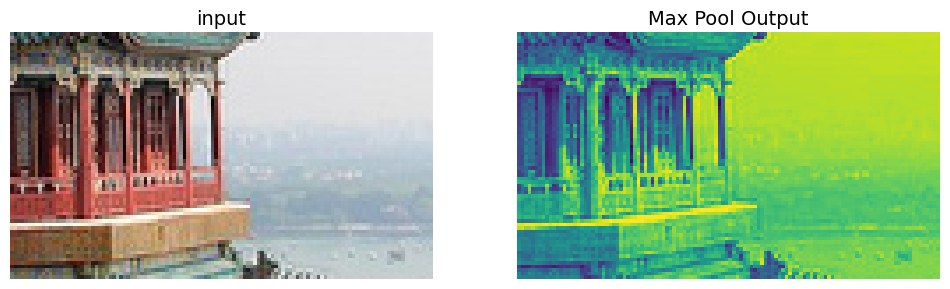

In [16]:
maxPoolImages = DepthPool(pool_size= 3)(images)
# plotting the dept wise max pool image 
plt.figure(figsize=(12, 9))
plt.subplot(1, 2, 1)
plt.title("input")
plt.axis("off")
plt.imshow(images[0])

plt.subplot(1, 2, 2)
plt.title("Max Pool Output")
plt.axis("off")
plt.imshow(maxPoolImages[0, ..., 0])

plt.show()

testing mnist fashion data using CNN

In [17]:
mnist = tf.keras.datasets.fashion_mnist.load_data()
(xTrainFull, yTrainFull), (xTest, yTest) = mnist
xTrainFull.shape

(60000, 28, 28)

In [18]:
xTrainFull = np.expand_dims(xTrainFull, axis=-1).astype(np.float32) / 255
xTest = np.expand_dims(xTest.astype(np.float32), axis=-1) / 255

xTrainFull.shape

(60000, 28, 28, 1)

In [19]:
xTest.shape

(10000, 28, 28, 1)

In [20]:
xTrain, xVal = xTrainFull[:-5000] , xTrainFull[-5000 : ]
yTrain , yVal = yTrainFull[:-5000] , yTrainFull[-5000 : ]

In [21]:
from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size = 3, padding = "same", kernel_initializer = "he_normal", activation = "relu")

model = tf.keras.Sequential([
    DefaultConv2D(filters = 64, input_shape = [28, 28, 1], kernel_size = 7),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters = 128),
    DefaultConv2D(filters = 128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters = 256),
    DefaultConv2D(filters = 256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 128, activation= "relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units = 64, activation= "relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units = 10, activation="softmax")
])

model.compile(loss = "sparse_categorical_crossentropy", optimizer = "nadam", metrics = ["accuracy"])
history = model.fit(xTrain, yTrain, validation_data = (xVal, yVal), epochs = 10)
score = model.evaluate(xTest, yTest)
print(f"score : {score}")

/home/furrukh/furrukhUbuntu/sk-learn/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


I0000 00:00:1756321617.072587    4400 service.cc:152] XLA service 0x7f269c00fb50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756321617.072613    4400 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-08-28 00:06:57.172759: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  20/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.0863 - loss: 2.9118  

I0000 00:00:1756321620.837983    4400 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6083 - loss: 1.0994

2025-08-28 00:07:13.570833: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_104', 12 bytes spill stores, 12 bytes spill loads

2025-08-28 00:07:13.743894: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_104', 4 bytes spill stores, 4 bytes spill loads



1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.6084 - loss: 1.0992 - val_accuracy: 0.8694 - val_loss: 0.3713
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8482 - loss: 0.4509 - val_accuracy: 0.8814 - val_loss: 0.3283
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8762 - loss: 0.3672 - val_accuracy: 0.9018 - val_loss: 0.2712
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8944 - loss: 0.3227 - val_accuracy: 0.9080 - val_loss: 0.2644
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9024 - loss: 0.2900 - val_accuracy: 0.9114 - val_loss: 0.2564
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9090 - loss: 0.2698 - val_accuracy: 0.8980 - val_loss: 0.2838
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9128 - loss: 0.2572 - val_accuracy: 0.9040 - val_loss: 0.2777
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9198 - loss: 0.2336 - val_a

In [22]:
xNew = xTest[:10]
preditions = model.predict(xNew)

predClasses = np.argmax(preditions, axis =1)
predClasses

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

implementing ResNet34 

In [23]:
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size = 3,  padding = "same",use_bias = False, kernel_initializer = "he_normal")

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides = 1, activation = "relu", **kwarg):
        super().__init__(**kwarg)
        self.activation = tf.keras.activations.get(activation) 

        self.mainLayer = [
            DefaultConv2D(filters , strides = strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]

        self.skipLayer = []
        if strides > 1:
            self.skipLayer = [
                DefaultConv2D(filters, kernel_size = 1, strides = strides),
                tf.keras.layers.BatchNormalization()
            ]
    def call(self, inputs):
        z = inputs 
        for layer in self.mainLayer:
            z = layer(z)
        zSkip = inputs 
        for layer in self.skipLayer:
            zSkip = layer(zSkip)

        return self.activation(z + zSkip)

model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size= 7 , strides = 2, input_shape = [224, 224, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size= 3, strides = 2, padding = "same")
])
prevFilter = 64
for filter in [64]* 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if prevFilter == filter else 2
    model.add(ResidualUnit(filter, strides= strides))
    prevFilter = filter 

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units = 10, activation="softmax"))


creating the model using keras built in models

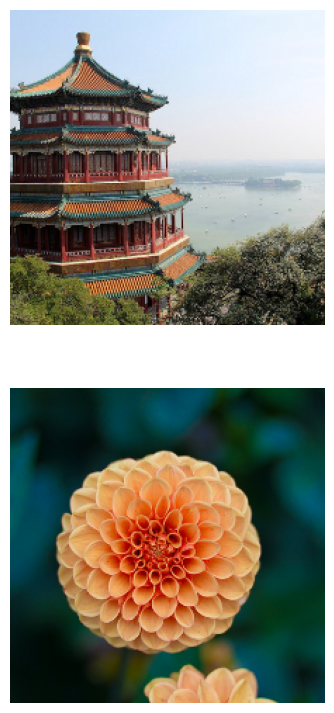

In [24]:
model = tf.keras.applications.ResNet50(weights = "imagenet")

images = tf.constant(load_sample_images()["images"])
resizedImages = tf.keras.layers.Resizing(width= 224, height= 224, crop_to_aspect_ratio=True)(images)

plt.figure(figsize = (10, 9))
for id in (0, 1):
    plt.subplot(2, 1 , id + 1)
    plt.imshow(resizedImages[id]/255)
    plt.axis("off")

plt.show()

In [25]:
inputs = tf.keras.applications.resnet50.preprocess_input(resizedImages)
yProb = model.predict(inputs)
yProb.shape

2025-08-28 00:08:51.129618: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1678', 8 bytes spill stores, 8 bytes spill loads

2025-08-28 00:08:51.579114: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1678', 120 bytes spill stores, 120 bytes spill loads

2025-08-28 00:08:51.597090: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1678', 12 bytes spill stores, 12 bytes spill loads

2025-08-28 00:08:51.785134: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1678', 3876 bytes spill stores, 3868 bytes spill loads

2025-08-28 00:08:51.962974: I extern

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


(2, 1000)

In [26]:
top_k = tf.keras.applications.resnet50.decode_predictions(yProb, top = 5)
for imageId in (0,1):
    print(f"image # {imageId}")
    for classId, name , prob in top_k[imageId]:
        print(f"classid : {classId}, name : {name}, probability : {prob:.2%}")

image # 0
classid : n03877845, name : palace, probability : 54.85%
classid : n03781244, name : monastery, probability : 24.41%
classid : n02825657, name : bell_cote, probability : 18.70%
classid : n02980441, name : castle, probability : 0.79%
classid : n04346328, name : stupa, probability : 0.34%
image # 1
classid : n04522168, name : vase, probability : 32.21%
classid : n11939491, name : daisy, probability : 17.87%
classid : n03530642, name : honeycomb, probability : 11.98%
classid : n13040303, name : stinkhorn, probability : 4.47%
classid : n07930864, name : cup, probability : 4.19%


In [27]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
datasetSize = info.splits["train"].num_examples
classNames = info.features["label"].names
numClasses = info.features["label"].num_classes

In [28]:
datasetSize

3670

In [29]:
classNames

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [30]:
numClasses

5

2025-08-28 00:08:54.768685: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-08-28 00:08:54.993223: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-08-28 00:08:54.997252: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


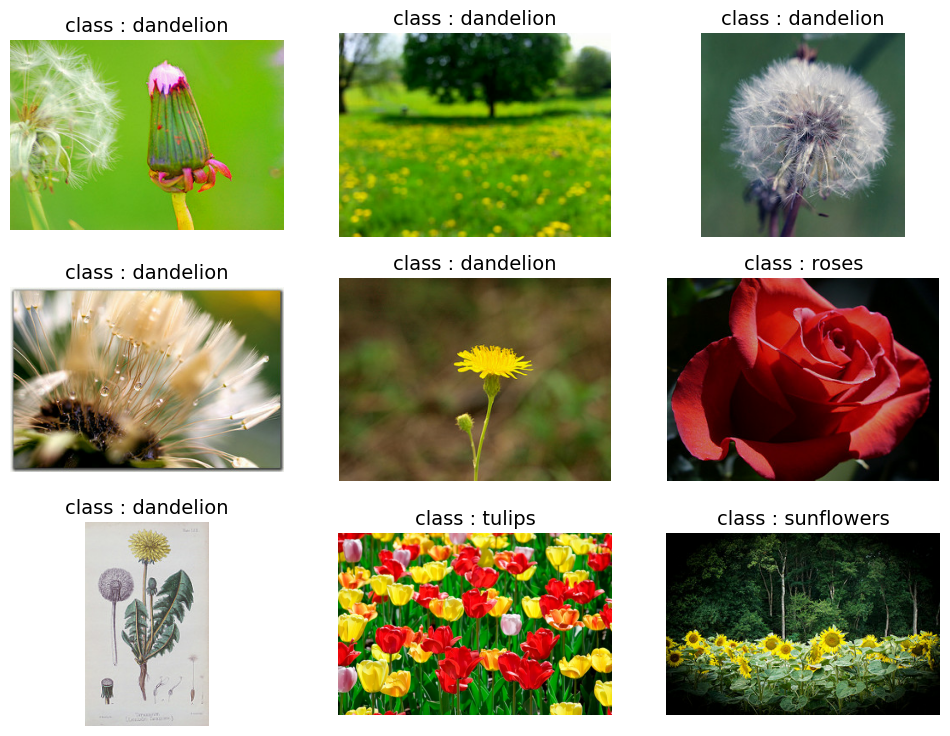

In [31]:
testRaw, validRaw, trainRaw = tfds.load("tf_flowers", split=["train[:10%]", "train[10%:25%]", "train[25%:]"], as_supervised=True)

plt.figure(figsize=(12, 9))
index = 0
for image, label in validRaw.take(9):
    index += 1
    plt.subplot(3,3, index)
    plt.imshow(image)
    plt.title(f"class : {classNames[label]}")
    plt.axis("off")
plt.show()

preprocessing the data

2025-08-28 00:08:56.875375: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-08-28 00:08:56.908145: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


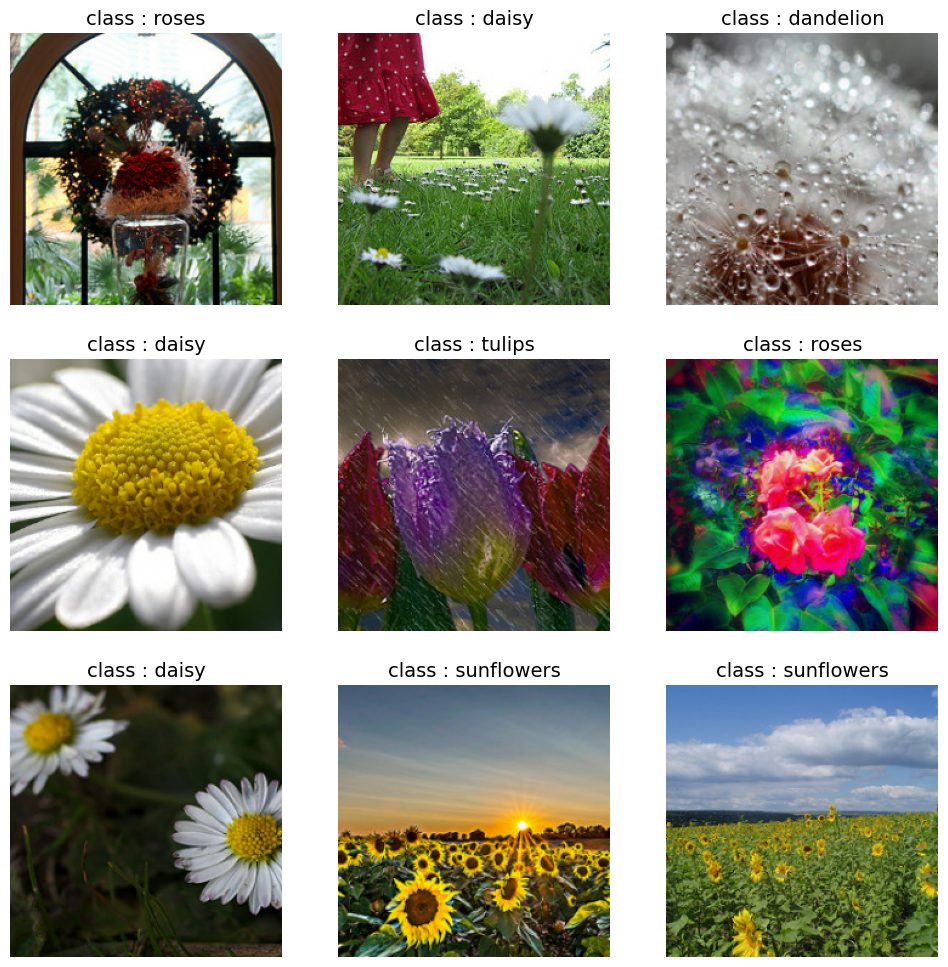

In [ ]:
tf.keras.backend.clear_session()
batchSize = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(width = 224, height = 224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
trainSet = trainRaw.map(lambda X, y:(preprocess(X), y))
trainSet = trainSet.shuffle(1000, seed = 42).batch(batchSize).prefetch(1)
# here you add the augmented data, layer of which is made in snippets below but was never shown in book how to use it
# trainSet = trainSet.map(lambda X, y:(data_augmentation(X, training = True), y))

validSet = validRaw.map(lambda X, y : (preprocess(X), y)).batch(batchSize)
testSet = testRaw.map(lambda X, y : (preprocess(X), y)).batch(batchSize)


# displaying 9 images 
plt.figure(figsize = (12, 12))
for xBatch, yBatch in validSet.take(9):
    for i in range(9):
        plt.subplot(3,3, i + 1)
        plt.imshow((xBatch[i] + 1)/2)
        plt.title(f"class : {classNames[yBatch[i]]}")
        plt.axis("off")
plt.show()


2025-08-28 00:46:55.640599: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-08-28 00:46:55.740377: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


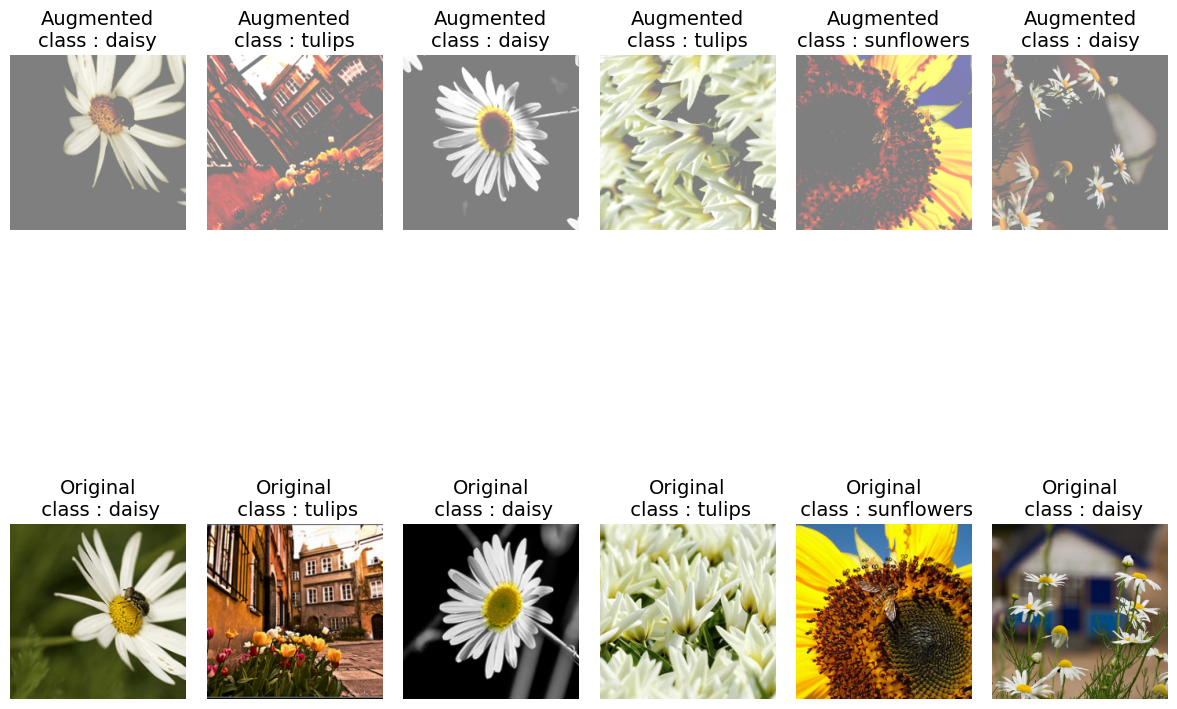

In [35]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode = "horizontal", seed = 42),
    tf.keras.layers.RandomRotation(factor=0.35, seed = 42),
    tf.keras.layers.RandomContrast(factor = 0.2, seed = 42)

])

plt.figure(figsize=(12, 12))
for xBatch , yBatch in validSet.take(6):
    xBatchAugmented = data_augmentation(xBatch, training = True)
    # plt.title("Augmented")
    for i in range(6):
        plt.subplot(2, 6, i+ 1)
        plt.imshow(np.clip((xBatchAugmented[i] + 1)/2 , 0, 1))
        plt.title(f"Augmented\nclass : {classNames[yBatch[i]]}")
        plt.axis("off")
    # plt.title("Original")
    for i in range(7, 13):
        plt.subplot(2, 6, i)
        plt.imshow((xBatch[i - 7] + 1)/2)
        plt.title(f"Original\n class : {classNames[yBatch[i -7]]}")
        plt.axis("off")
plt.tight_layout()
plt.show() 
        

In [36]:
tf.random.set_seed(42)
baseModel = tf.keras.applications.xception.Xception(weights = "imagenet", include_top=False)
avg = tf.keras.layers.GlobalAvgPool2D()(baseModel.output)
output = tf.keras.layers.Dense(numClasses, activation="softmax")(avg)

model = tf.keras.Model(inputs = baseModel.input, outputs = output)



freeze the weights of the base model in initial training 

In [37]:
len(baseModel.layers)

132

In [38]:
for layer in baseModel.layers:
    layer.trainable = False 

In [39]:
optimizer = tf.keras.optimizers.SGD(learning_rate= 0.1, momentum= 0.9)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
history = model.fit(trainSet, validation_data=validSet, epochs = 3)

Epoch 1/3


2025-08-28 01:41:24.808484: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3896', 212 bytes spill stores, 212 bytes spill loads

2025-08-28 01:41:24.863748: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3896', 76 bytes spill stores, 76 bytes spill loads

2025-08-28 01:41:25.114640: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3896', 3816 bytes spill stores, 3796 bytes spill loads

2025-08-28 01:41:25.272597: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3896', 4168 bytes spill stores, 4152 bytes spill loads

2025-08-28 01:41:31.901529: W 

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7079 - loss: 0.9242

2025-08-28 01:41:46.235563: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1030', 132 bytes spill stores, 132 bytes spill loads

2025-08-28 01:41:46.283882: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1030', 4 bytes spill stores, 4 bytes spill loads

2025-08-28 01:41:46.515519: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1030', 1416 bytes spill stores, 1416 bytes spill loads

2025-08-28 01:41:49.266484: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performanc

86/86 ━━━━━━━━━━━━━━━━━━━━ 31s 192ms/step - accuracy: 0.7090 - loss: 0.9220 - val_accuracy: 0.8584 - val_loss: 0.6081
Epoch 2/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.9118 - loss: 0.3487 - val_accuracy: 0.8403 - val_loss: 0.6859
Epoch 3/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.9342 - loss: 0.2228 - val_accuracy: 0.8439 - val_loss: 0.6184


now unfreezing top layers 56 and above 

In [40]:
for layer in baseModel.layers[56:]:
    layer.trainable = True 

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
history = model.fit(trainSet, validation_data=validSet, epochs = 10)

Epoch 1/10


2025-08-28 01:42:25.925852: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-28 01:42:26.276209: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-28 01:42:26.468644: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


86/86 ━━━━━━━━━━━━━━━━━━━━ 31s 207ms/step - accuracy: 0.8664 - loss: 0.3834 - val_accuracy: 0.8475 - val_loss: 0.8035
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 168ms/step - accuracy: 0.9780 - loss: 0.0723 - val_accuracy: 0.9056 - val_loss: 0.3920
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - accuracy: 0.9938 - loss: 0.0236 - val_accuracy: 0.9093 - val_loss: 0.4331
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 176ms/step - accuracy: 0.9967 - loss: 0.0113 - val_accuracy: 0.9165 - val_loss: 0.3009
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - accuracy: 0.9981 - loss: 0.0047 - val_accuracy: 0.9201 - val_loss: 0.3098
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 16s 180ms/step - accuracy: 0.9989 - loss: 0.0051 - val_accuracy: 0.9183 - val_loss: 0.3399
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 171ms/step - accuracy: 0.9980 - loss: 0.0052 - val_accuracy: 0.9147 - val_loss: 0.3680
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 16s 183ms/step - accuracy: 0.9991 - loss: 0.0025 - val_accuracy: 0.922